In [22]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-07-27 09:37:11,935: Credentials are already in use. The existing account in the session will be replaced.


In [23]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *

In [24]:
cir = QuantumCircuit(2,2)

In [25]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')

ibmqfactory.load_account:WARNING:2022-07-27 09:37:18,094: Credentials are already in use. The existing account in the session will be replaced.


In [26]:
backend_config = backend.configuration()

In [27]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


In [28]:
backend.configuration().timing_constraints

{'acquire_alignment': 16,
 'granularity': 16,
 'min_length': 64,
 'pulse_alignment': 1}

In [29]:
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

In [30]:
import numpy as np

lcm = np.lcm(acquire_alignment, pulse_alignment)
print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

Least common multiple of acquire_alignment and pulse_alignment: 16


In [31]:
backend_defaults = backend.defaults()

In [32]:
#Finding the qubit Frequency using a Frequency Sweep

In [33]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 5.260490357775302 GHz.
The sweep will go from 5.240490357775302 GHz to 5.280490357775302 GHz in steps of 1.0 MHz.


In [34]:
def get_closest_multiple_of(vaule, base_number):
    return int(vaule + base_number/2) - (int(vaule + base_number/2) % base_number)

In [35]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

In [36]:
# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

In [37]:
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate

# Drive pulse parameters (us = microseconds)
drive_sigma_sec = 0.015 * us                           # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8                # This is a truncating parameter, because gaussians don't have 
                                                        # a natural finite length
drive_amp = 0.05

# Create the base schedule
# Start with drive pulse acting on the drive channel
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    # Drive pulse samples
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)

In [38]:
sweep_gate = Gate("sweep", 1, [freq])

qc_sweep = QuantumCircuit(1, 1)

qc_sweep.append(sweep_gate, [0])
qc_sweep.measure(0, 0)
qc_sweep.add_calibration(sweep_gate, (0,), sweep_sched, [freq])

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

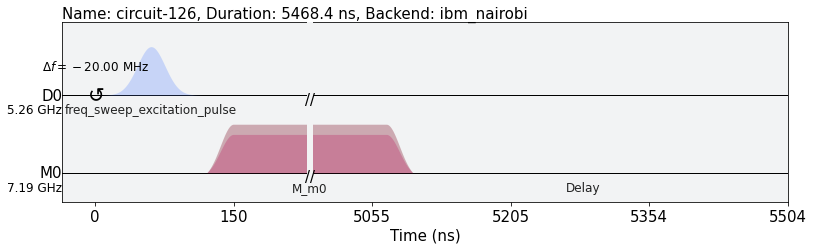

In [39]:
from qiskit import schedule

sweep_schedule = schedule(exp_sweep_circs[0], backend)
sweep_schedule.draw(backend=backend)

In [40]:
num_shots_per_frequency = 1024

job = backend.run(exp_sweep_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)

In [41]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has been cancelled


In [42]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

Traceback (most recent call last):
  Input In [42] in <cell line: 1>
    frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds
  File /opt/conda/lib/python3.8/site-packages/qiskit/providers/ibmq/job/ibmqjob.py:279 in result
    raise IBMQJobInvalidStateError('Unable to retrieve result for job {}. '
IBMQJobInvalidStateError: 'Unable to retrieve result for job 62e1076122b5f501a4565992. Job was cancelled.'

Use %tb to get the full traceback.


In [ ]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [ ]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [ ]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [1, 4.975, 1, -2] # initial parameters for curve_fit
                                )

In [ ]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [ ]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

In [ ]:
#Calibrating and using a Pi Pulse

In [ ]:
#Calibrating  Pulses using a Rabi Experiment

In [ ]:
# This experiment uses these values from the previous experiment:
# `qubit`,and
# `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [ ]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.

drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)

In [ ]:
rabi_gate = Gate("rabi", 1, [drive_amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [drive_amp])

exp_rabi_circs = [qc_rabi.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

In [ ]:
rabi_schedule = schedule(exp_rabi_circs[-1], backend)
rabi_schedule.draw(backend=backend)

In [ ]:
num_shots_per_point = 1024

job = backend.run(exp_rabi_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)

job_monitor(job)

In [ ]:
rabi_results = job.result(timeout=120)

In [ ]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

In [ ]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

In [ ]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [2, 0, 0.2, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [ ]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

In [ ]:
#Our Pi pulse!

In [ ]:
with pulse.build(backend) as pi_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

In [ ]:
#Determining 0 vs 1

In [1]:
# Ground state 
qc_gnd = QuantumCircuit(1, 1)
qc_gnd.measure(0, 0)

Traceback (most recent call last):
  Input In [1] in <cell line: 2>
    qc_gnd = QuantumCircuit(1, 1)
NameError: name 'QuantumCircuit' is not defined

Use %tb to get the full traceback.


In [ ]:
gnd_schedule = schedule(qc_gnd, backend)
gnd_schedule.draw(backend=backend)

In [ ]:
# Excited state
with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse)

In [ ]:
qc_exc = QuantumCircuit(1, 1)
qc_exc.x(0)
qc_exc.measure(0, 0)

qc_exc.add_calibration("x", (0,), exc_schedule, [])

In [ ]:
exec_schedule = schedule(qc_exc, backend)
exec_schedule.draw(backend=backend)

In [ ]:
# Execution settings
num_shots = 1024

job = backend.run([qc_gnd, qc_exc], 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

In [ ]:
gnd_exc_results = job.result(timeout=120)

In [ ]:
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

plt.figure()

# Plot all the results
# All results from the ground state are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the excited state are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

plt.axis('square')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()

In [ ]:
import math

def classify(point: complex):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))

In [ ]:
# Measuring T1 using Inversion Recovery

In [ ]:
# T1 experiment parameters
time_max_sec = 450 * us
time_step_sec = 6.5 * us
delay_times_sec = np.arange(1 * us, time_max_sec, time_step_sec)

# We will use the same `pi_pulse` and qubit frequency that we calibrated and used before

In [ ]:
delay = Parameter('delay')
qc_t1 = QuantumCircuit(1, 1)

qc_t1.x(0)
qc_t1.delay(delay, 0)
qc_t1.measure(0, 0)
qc_t1.add_calibration("x", (0,), pi_pulse)

exp_t1_circs = [qc_t1.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

In [ ]:
sched_idx = -1
t1_schedule = schedule(exp_t1_circs[sched_idx], backend)
t1_schedule.draw(backend=backend)

In [ ]:
# Execution settings
num_shots = 256

job = backend.run(exp_t1_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

In [ ]:
t1_results = job.result(timeout=120)

In [ ]:
t1_values = []

for i in range(len(delay_times_sec)):
    iq_data = t1_results.get_memory(i)[:,qubit] * scale_factor
    t1_values.append(sum(map(classify, iq_data)) / num_shots)

plt.scatter(delay_times_sec/us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

In [ ]:
# Fit the data
fit_params, y_fit = fit_function(delay_times_sec/us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(delay_times_sec/us, t1_values, color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

In [ ]:
#Determining qubit Coherence

In [ ]:
#Measuring the qubit Frequency Precisely using a Ramsey Experiment

In [60]:
# Ramsey experiment parameters
time_max_sec = 1.8 * us
time_step_sec = 0.025 * us
delay_times_sec = np.arange(0.1 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

In [61]:
detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

In [62]:
# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [63]:
ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

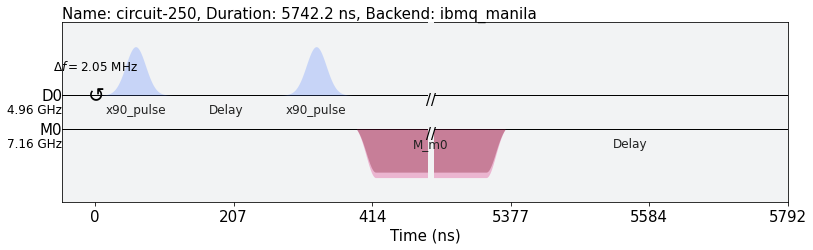

In [64]:
ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

In [65]:
# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [66]:
ramsey_results = job.result(timeout=120)

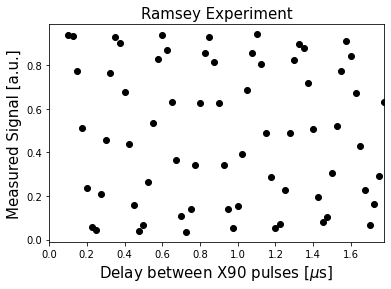

In [67]:
ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

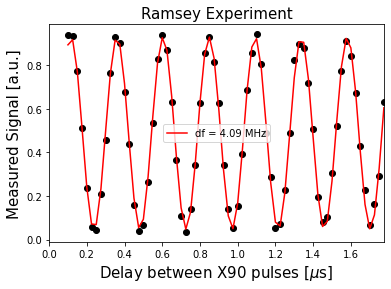

In [68]:
fit_params, y_fit = fit_function(delay_times_sec/us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [1, 4, 0, 0.3]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(delay_times_sec/us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

In [ ]:
#aquí añadimos para observar el experimento de sensing en Ramsey

In [69]:
# Ramsey experiment parameters
time_max_sec = 5 * us
time_step_sec = 0.25 * us
delay_times_sec = np.arange(0.1 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

In [70]:
detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

In [71]:
# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [72]:
ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

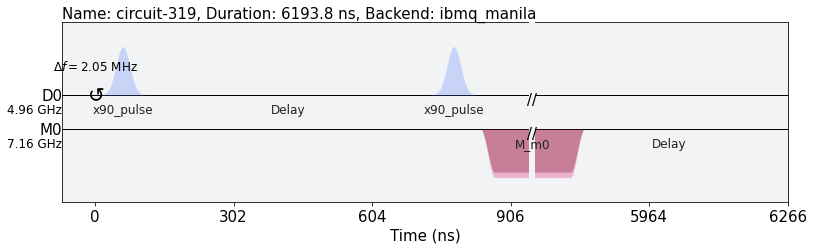

In [73]:
ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

In [74]:
# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [75]:
ramsey_results = job.result(timeout=120)

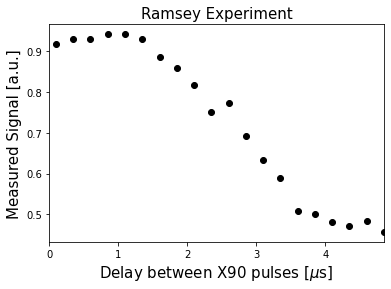

In [76]:
ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

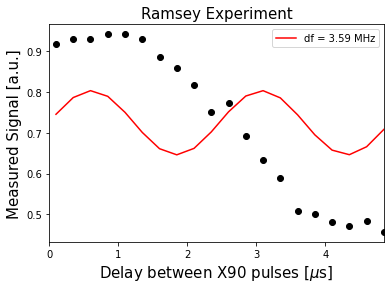

In [77]:
fit_params, y_fit = fit_function(delay_times_sec/us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [1, 3.5, 0, 0.25]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(delay_times_sec/us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

In [78]:
# Ramsey experiment parameters
time_max_sec = 10 * us
time_step_sec = 0.25 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

In [79]:
detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

In [80]:
# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [81]:
ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

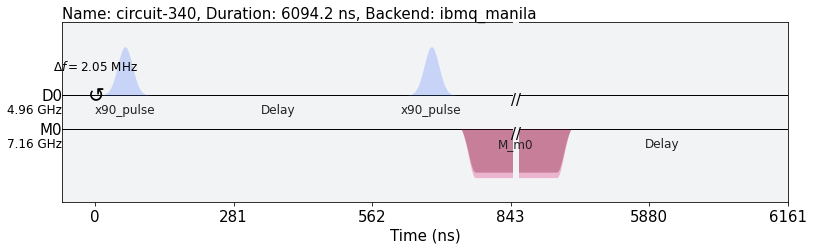

In [82]:
ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

In [83]:
# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [84]:
ramsey_results = job.result(timeout=120)

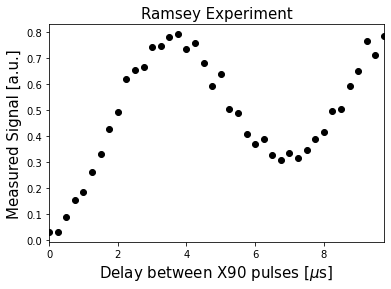

In [85]:
ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

In [86]:
# Ramsey experiment parameters
time_max_sec = 15 * us
time_step_sec = 0.25 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

In [87]:
detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

In [88]:
# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [89]:
ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

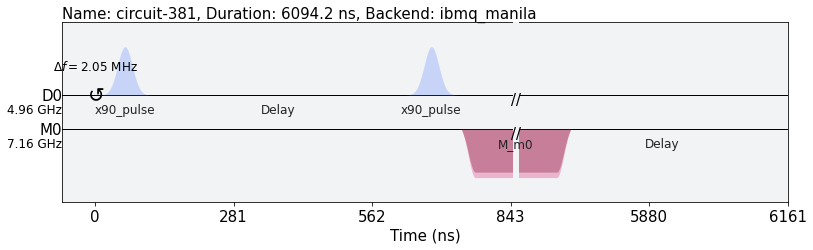

In [90]:
ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

In [91]:
# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [92]:
ramsey_results = job.result(timeout=120)

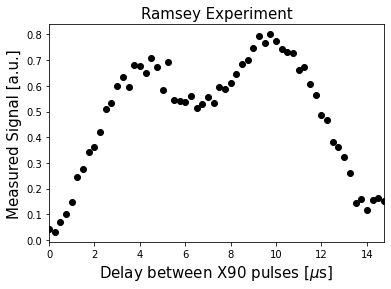

In [93]:
ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

In [94]:
# Ramsey experiment parameters
time_max_sec = 20 * us
time_step_sec = 0.25 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

In [95]:
detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

In [96]:
# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [97]:
ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

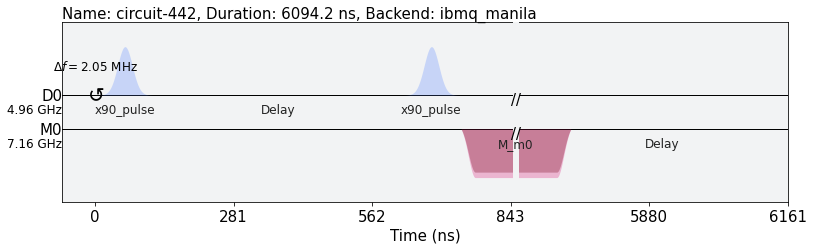

In [98]:
ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

In [99]:
# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [100]:
ramsey_results = job.result(timeout=120)

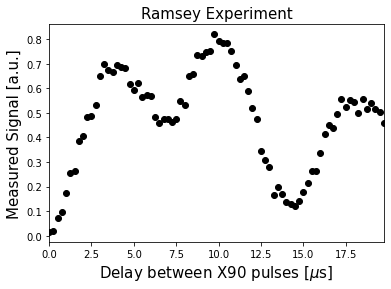

In [101]:
ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

In [102]:
# Ramsey experiment parameters
time_max_sec = 25 * us
time_step_sec = 0.25 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

In [103]:
detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

In [104]:
# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [105]:
ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

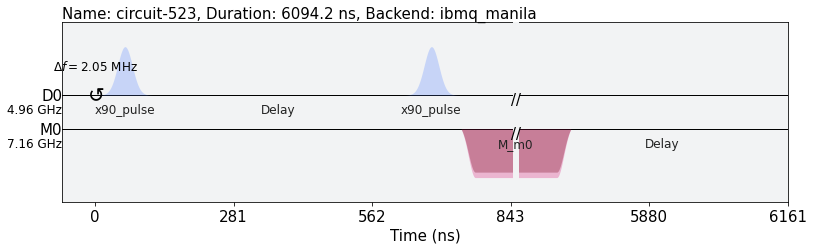

In [106]:
ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

In [107]:
# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [108]:
ramsey_results = job.result(timeout=120)

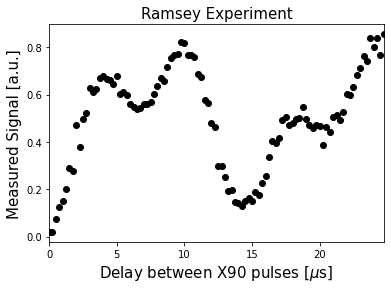

In [109]:
ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


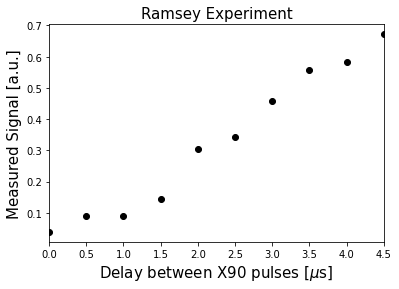

In [110]:
# Ramsey experiment parameters
time_max_sec = 5 * us
time_step_sec = 0.5 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()


Job Status: job has successfully run


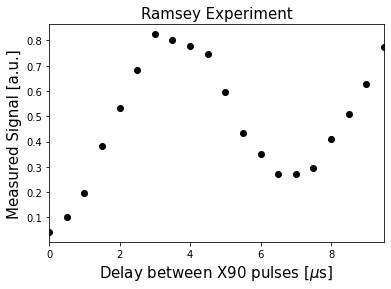

In [111]:
# Ramsey experiment parameters
time_max_sec = 10 * us
time_step_sec = 0.5 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()


Job Status: job has successfully run


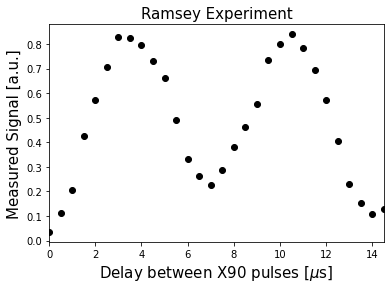

In [112]:
# Ramsey experiment parameters
time_max_sec = 15 * us
time_step_sec = 0.5 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()


Job Status: job has successfully run


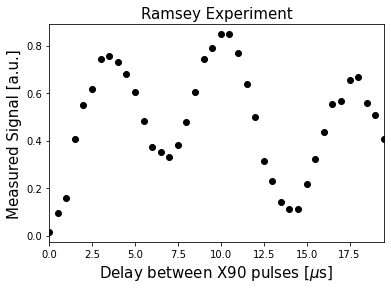

In [113]:
# Ramsey experiment parameters
time_max_sec = 20 * us
time_step_sec = 0.5 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()


Job Status: job has successfully run


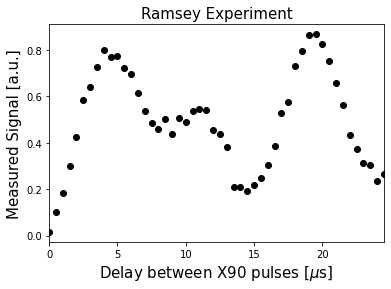

In [114]:
# Ramsey experiment parameters
time_max_sec = 25 * us
time_step_sec = 0.5 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()


Job Status: job has successfully run


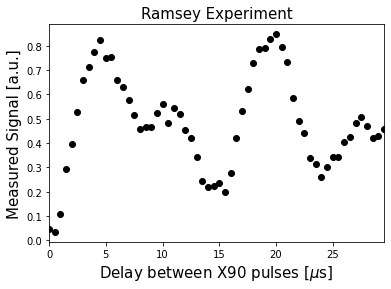

In [115]:
# Ramsey experiment parameters
time_max_sec = 30 * us
time_step_sec = 0.5 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()


Job Status: job has successfully run


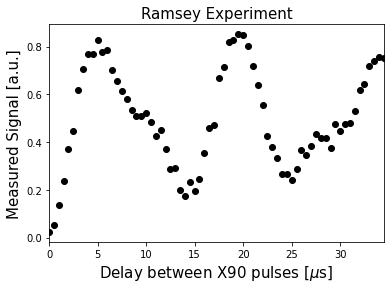

In [116]:
# Ramsey experiment parameters
time_max_sec = 35 * us
time_step_sec = 0.5 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()


Job Status: job has successfully run


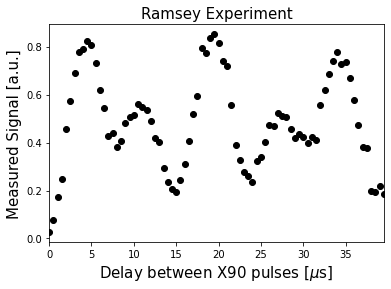

In [117]:
# Ramsey experiment parameters
time_max_sec = 40 * us
time_step_sec = 0.5 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()


Job Status: job has successfully run


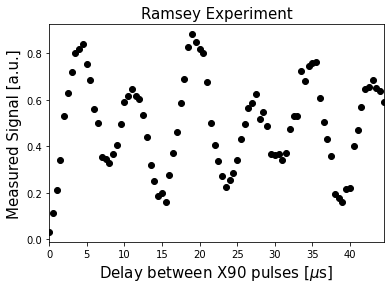

In [118]:
# Ramsey experiment parameters
time_max_sec = 45 * us
time_step_sec = 0.5 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()


Job Status: job has successfully run


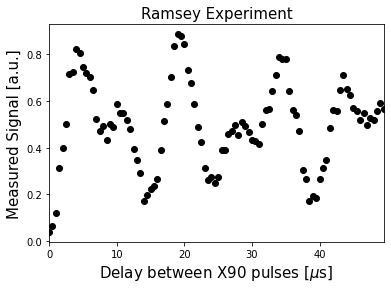

In [119]:
# Ramsey experiment parameters
time_max_sec = 50 * us
time_step_sec = 0.5 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()


Job Status: job has successfully run


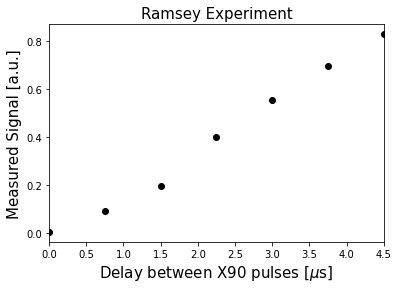

In [120]:
# Ramsey experiment parameters
time_max_sec = 5 * us
time_step_sec = 0.75 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()


Job Status: job has successfully run


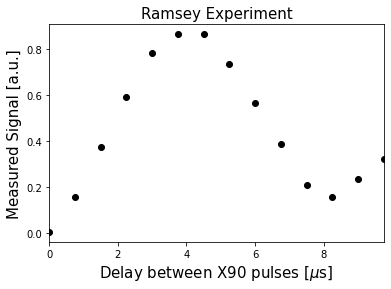

In [121]:
# Ramsey experiment parameters
time_max_sec = 10 * us
time_step_sec = 0.75 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


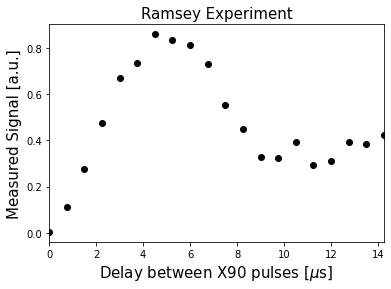

In [122]:
# Ramsey experiment parameters
time_max_sec = 15 * us
time_step_sec = 0.75 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


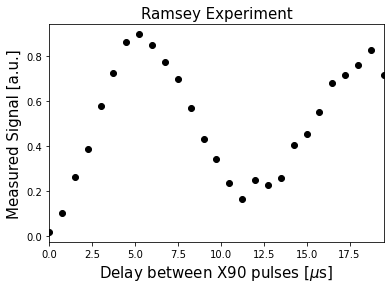

In [123]:
# Ramsey experiment parameters
time_max_sec = 20 * us
time_step_sec = 0.75 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


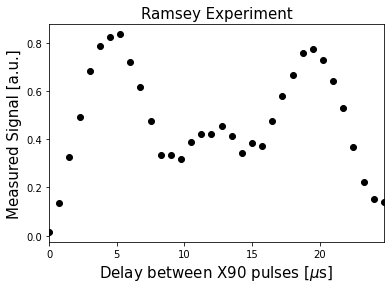

In [124]:
# Ramsey experiment parameters
time_max_sec = 25 * us
time_step_sec = 0.75 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


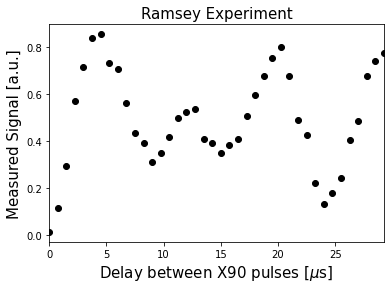

In [125]:
# Ramsey experiment parameters
time_max_sec = 30 * us
time_step_sec = 0.75 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


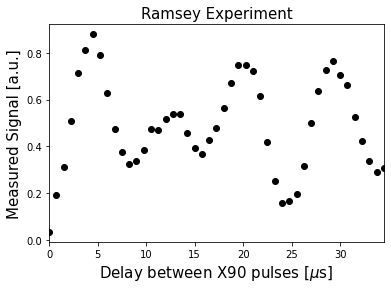

In [126]:
# Ramsey experiment parameters
time_max_sec = 35 * us
time_step_sec = 0.75 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


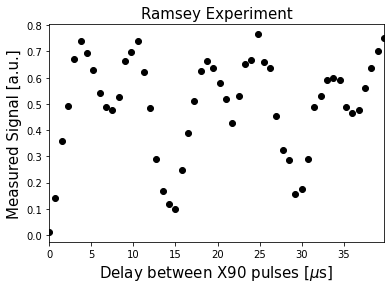

In [127]:
# Ramsey experiment parameters
time_max_sec = 40 * us
time_step_sec = 0.75 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


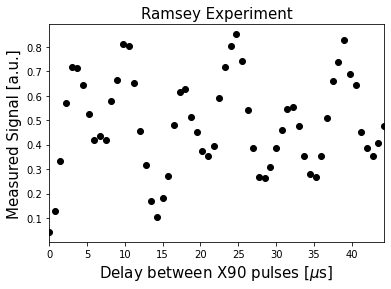

In [128]:
# Ramsey experiment parameters
time_max_sec = 45 * us
time_step_sec = 0.75 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


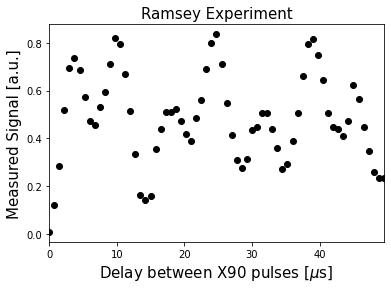

In [129]:
# Ramsey experiment parameters
time_max_sec = 50 * us
time_step_sec = 0.75 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


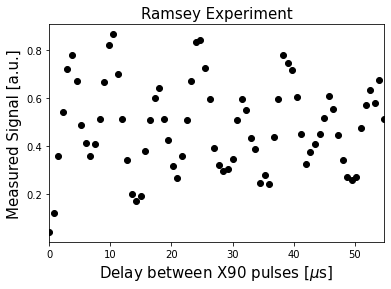

In [130]:
# Ramsey experiment parameters
time_max_sec = 55 * us
time_step_sec = 0.75 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


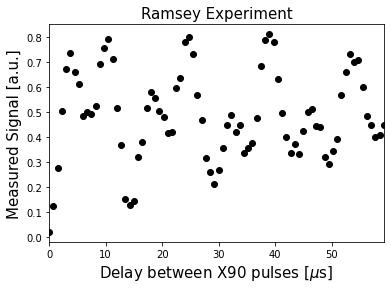

In [131]:
# Ramsey experiment parameters
time_max_sec = 60 * us
time_step_sec = 0.75 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


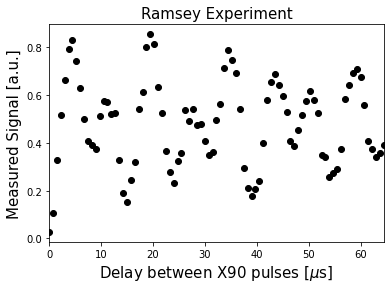

In [132]:
# Ramsey experiment parameters
time_max_sec = 65 * us
time_step_sec = 0.75 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


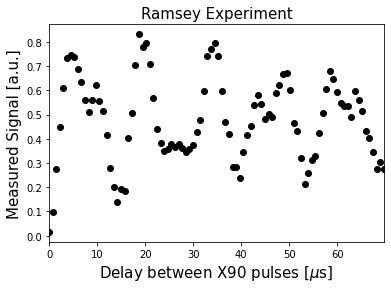

In [133]:
# Ramsey experiment parameters
time_max_sec = 70 * us
time_step_sec = 0.75 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


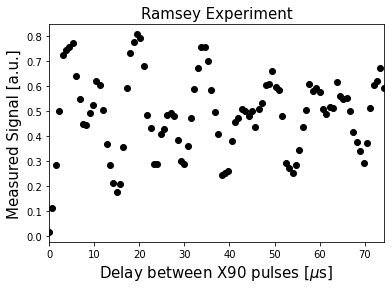

In [134]:
# Ramsey experiment parameters
time_max_sec = 75 * us
time_step_sec = 0.75 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


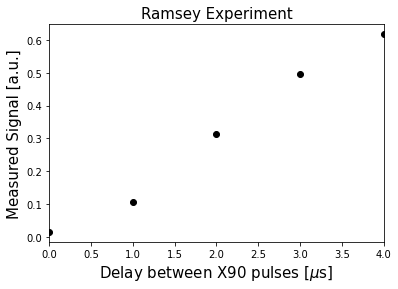

In [135]:
# Ramsey experiment parameters
time_max_sec = 5 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


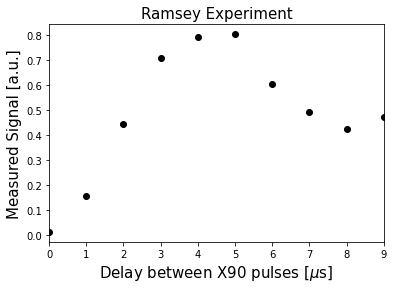

In [136]:
# Ramsey experiment parameters
time_max_sec = 10 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


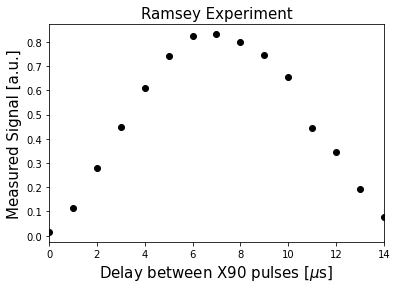

In [137]:
# Ramsey experiment parameters
time_max_sec = 15 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

In [ ]:
# Ramsey experiment parameters
time_max_sec = 20 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


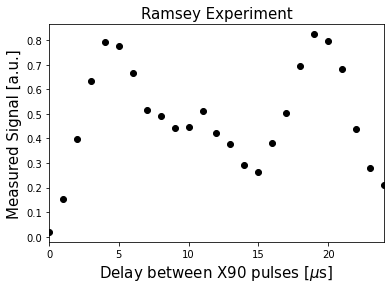

In [139]:
# Ramsey experiment parameters
time_max_sec = 25 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


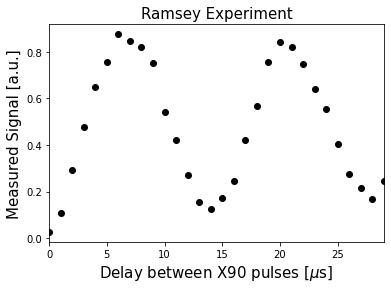

In [140]:
# Ramsey experiment parameters
time_max_sec = 30 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


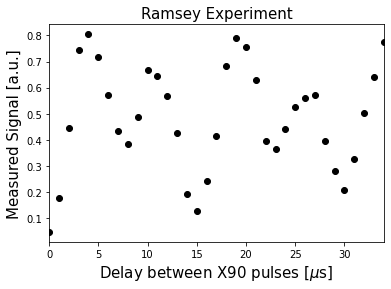

In [141]:
# Ramsey experiment parameters
time_max_sec = 35 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


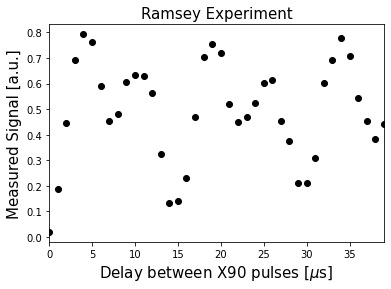

In [142]:
# Ramsey experiment parameters
time_max_sec = 40 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


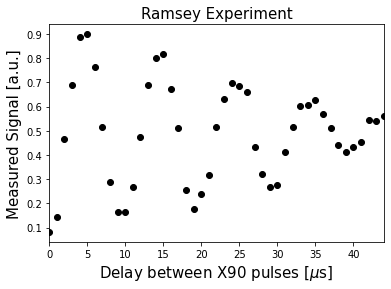

In [143]:
# Ramsey experiment parameters
time_max_sec = 45 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


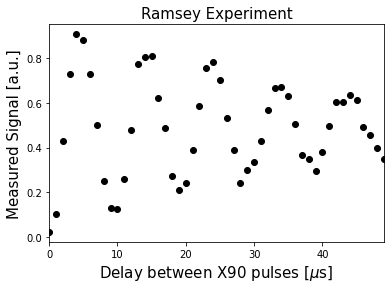

In [144]:
# Ramsey experiment parameters
time_max_sec = 50 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


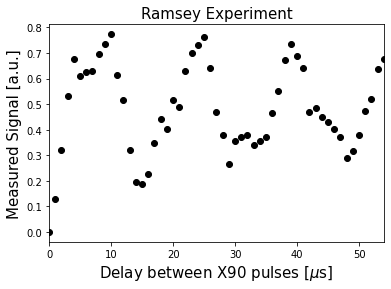

In [145]:
# Ramsey experiment parameters
time_max_sec = 55 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


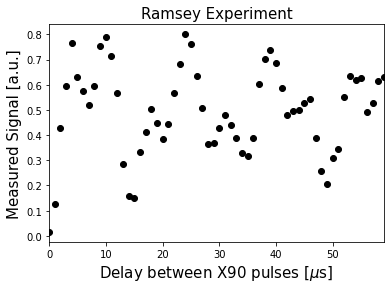

In [146]:
# Ramsey experiment parameters
time_max_sec = 60 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


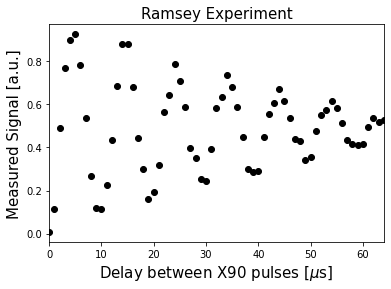

In [147]:
# Ramsey experiment parameters
time_max_sec = 65 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


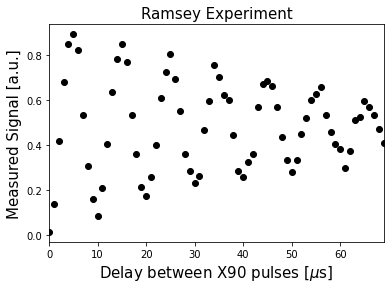

In [ ]:
# Ramsey experiment parameters
time_max_sec = 70 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


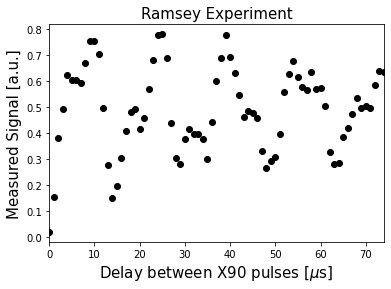

In [ ]:
# Ramsey experiment parameters
time_max_sec = 75 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


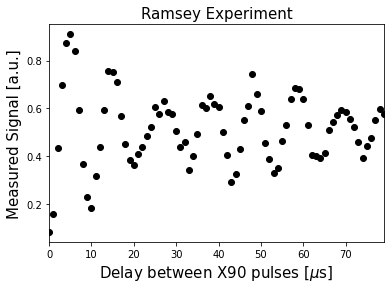

In [ ]:
# Ramsey experiment parameters
time_max_sec = 80 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


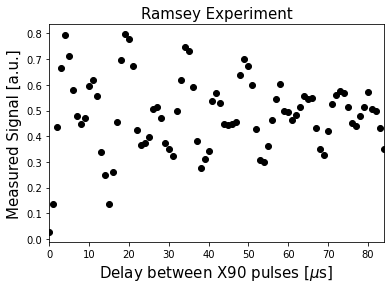

In [ ]:
# Ramsey experiment parameters
time_max_sec = 85 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


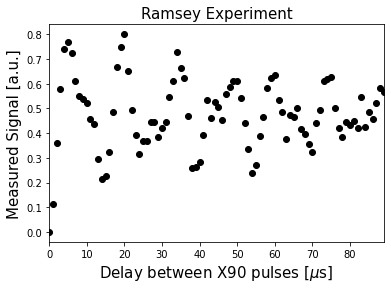

In [ ]:
# Ramsey experiment parameters
time_max_sec = 90 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job has successfully run


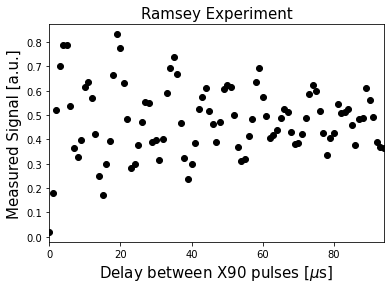

In [ ]:
# Ramsey experiment parameters
time_max_sec = 95 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

In [ ]:
# Ramsey experiment parameters
time_max_sec = 100 * us
time_step_sec = 1 * us
delay_times_sec = np.arange(0 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

##

detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

##

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

##

ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

##

ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

##

# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

##

ramsey_results = job.result(timeout=120)

##

ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

Job Status: job is queued (2)     